# Graph analysis for WILD mice reared without father

## Overview

This notebook performs various analyses on cell count data from different experimental groups. The primary tasks include:

1. **Loading Data**: Importing and cleaning cell count data.
2. **Statistical Analysis**: Performing statistical tests to identify significant areas.
3. **Graph Creation**: Generating and visualizing graphs based on correlation matrices.
4. **Data Visualization**: Creating histograms, boxplots, and other visualizations to analyze data distributions.

## Detailed Steps

**1. Load Data**

The notebook begins by loading and cleaning the volumes data using a custom function. It also loads results from a file and organizes experimental groups based on the subjects.

**2. Define Parameters**

- **Correlation Threshold**: A threshold for filtering correlations.
- **Significant Areas**: Areas that show statistically significant differences based on predefined criteria.

**3. Calculate Values Across Groups**

Cell counts are computed across different experimental groups using specific functions that aggregate the data.

**4. Cross-Correlation and Save Results**

Cross-correlation matrices are computed for different experimental conditions (e.g., control, fam, unfam). Results are saved as CSV files for further analysis.

**5. Create Graphs**

Graphs are generated from the correlation matrices. The notebook uses functions to create and visualize these graphs, showing relationships between significant areas.

**6. Plot Graphs**

Graphs are plotted using various layouts to visualize the connections between significant areas. The layout used is a spring layout, which helps in visualizing the structure of the network.

**7. Histogram and Boxplot Analysis**

Histograms and boxplots are created to analyze the distribution of graph degrees and correlation values. This helps in understanding the statistical properties of the data.

**8. Betweenness Centrality Analysis**

Betweenness centrality is calculated for the graphs to identify key nodes within the network. This analysis is used to determine the relative importance of nodes in terms of their connectivity within the graph.



In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import copy
import itertools
from utils_graphs import create_graph, plot_graph, get_colors, fig_graph_degrees
import utils_PLS as upls
import matplotlib.colors as cm
from matplotlib.lines import Line2D

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
experimental_group = 'WILD_without_father2500'
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy', allow_pickle=True).item()
subjects = list(dict_results_across_mice.keys())

experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

In [4]:
corr_threshold = 0.75
allen_order = list(volumes[volumes['st_level']==8]['acronym'])

In [5]:
df_levels = upls.create_df_levels(volumes, level=8)

# Analysis on number of cells

In [6]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count])
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count],
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

In [7]:
significant_areas = ace.select_significant_areas(dictionary=dict_results_across_mice, 
                                             experimental_groups=experimental_groups, 
                                             batch='WILD_without_father2500',
                                             test='mannwhitneyu', 
                                             threshold_test=0.05,
                                             threshold_pls=2.56,
                                             value_test='n_cells', 
                                             value_pls='relative_density')

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [28]:
G_control = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=significant_areas, 
                         corr_threshold=corr_threshold, correlations='one')
G_fam = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=significant_areas, 
                         corr_threshold=corr_threshold, correlations='one')
G_unfam = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=significant_areas, 
                         corr_threshold=corr_threshold, correlations='one')

## Graphs of positive correlations

(<Figure size 936x936 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2b4babc9b0>)

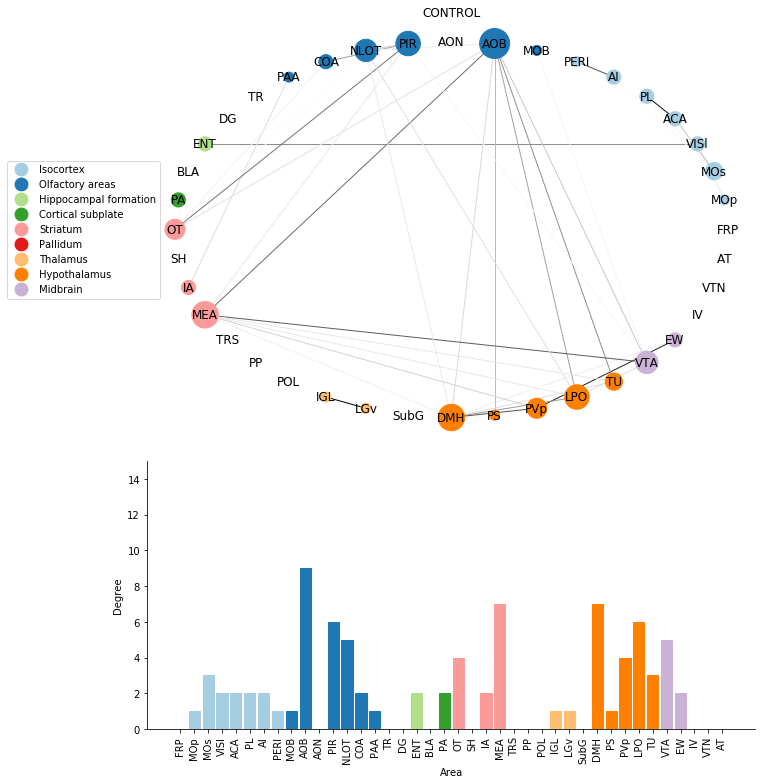

In [9]:
fig_graph_degrees(G=G_control, title='CONTROL', volumes=volumes, y_lim=15, figsize=(13,13), show_colorbar=False)

(<Figure size 936x936 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2b49039630>)

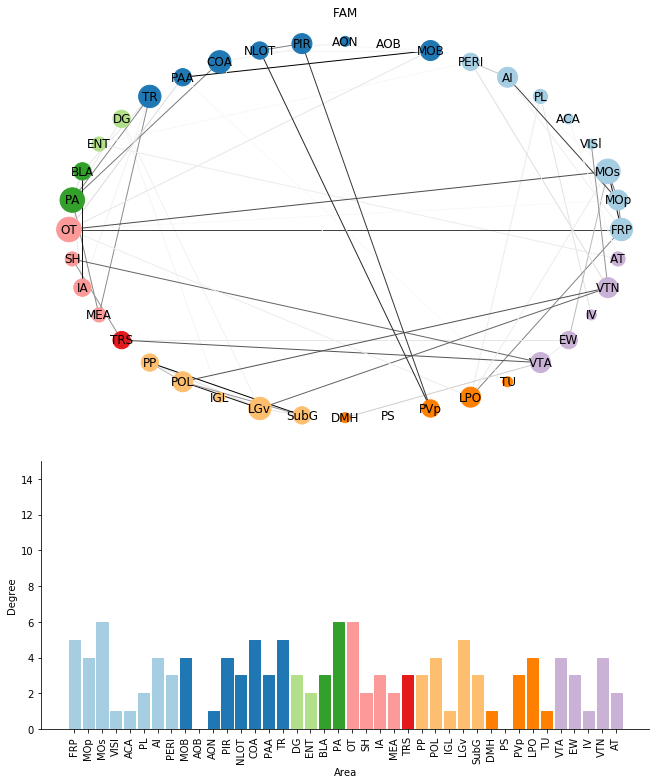

In [15]:
fig_graph_degrees(G=G_fam, title='FAM', volumes=volumes, show_colorbar=False, show_legend=False, 
                  y_lim=15, figsize=(13,13), show_degrees=True)


(<Figure size 936x936 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2b48e600b8>)

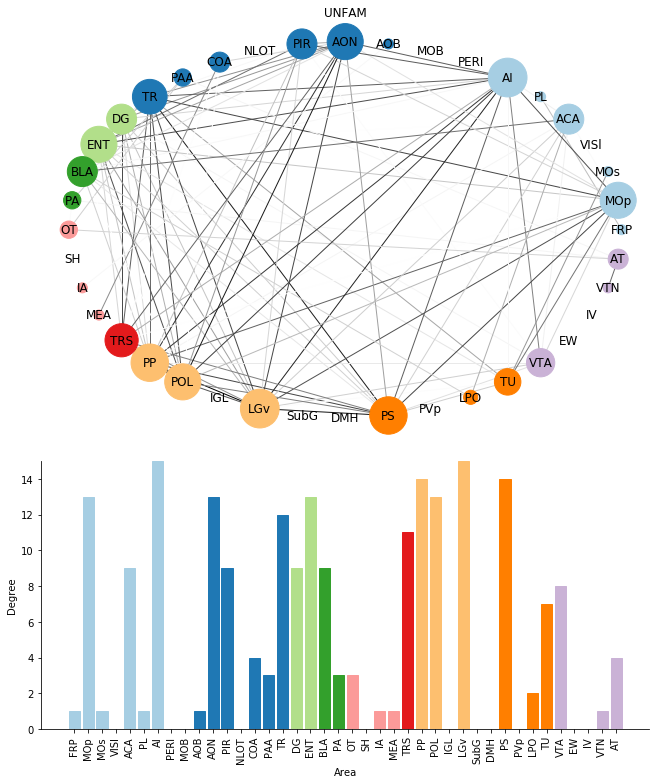

In [16]:
fig_graph_degrees(G=G_unfam, title='UNFAM', volumes=volumes, show_colorbar=False, show_legend=False, 
                  y_lim=15, figsize=(13,13), show_degrees=True)


## Using Spring layout

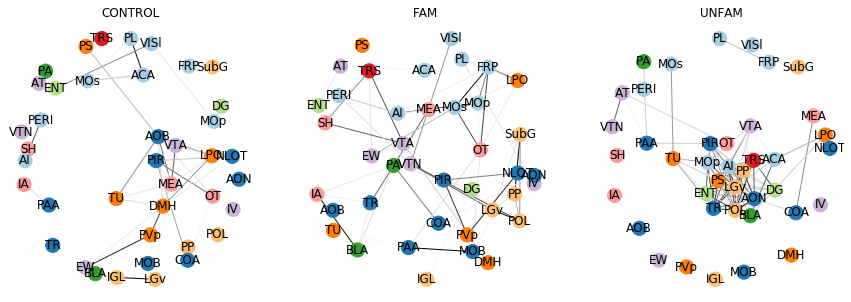

In [19]:
show_colorbar=True
show_legend=True
Gs = [G_control, G_fam, G_unfam]
titles=['CONTROL', 'FAM', 'UNFAM']
# create tables
allen_order = list(volumes[volumes['st_level']==8]['acronym'])
df_levels = upls.create_df_levels(volumes, level=8)

# create figure
fig = plt.figure(figsize=(15, 5))

edge_cmap = plt.cm.get_cmap('Greys')

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(1, 3)
# plot graph
for i, G in enumerate(Gs):
    ax = fig.add_subplot(axgrid[i])

    order=allen_order

    # Plot the network:
    # pos = nx.spring_layout(sorted(list(G.nodes()),
    #   key = order.index))
    pos = nx.spring_layout(G, k=1, seed=42)
    list_colors = get_colors(G, df_levels, order, volumes=volumes,
                            macroareas_to_exclude=['Pons', 'Medulla', 'Cerebellar cortex', 'Cerebellar nuclei'])[0]
    nx.draw(G, with_labels=True, node_color=list_colors, 
            node_size=200,font_size=12, pos=pos, ax=ax, edge_cmap=edge_cmap, width=1,
            edge_color=[G[u][v]['weight'] for u, v in G.edges])

    # relabel graphs
    ax.set_title(titles[i])


## Histogram degrees

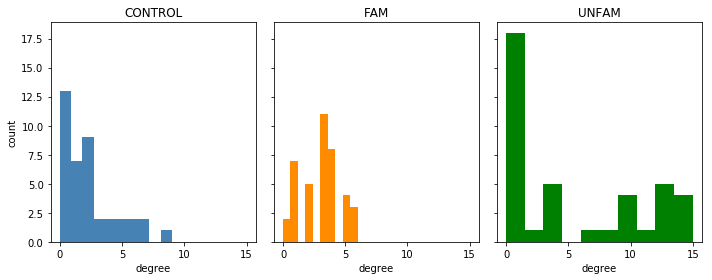

In [20]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axes[0].set_title('CONTROL')
axes[0].hist(list(dict(G_control.degree).values()),
            color='steelblue')
axes[1].set_title('FAM')
axes[1].hist(list(dict(G_fam.degree).values()),
            color='darkorange')
axes[2].set_title('UNFAM')
axes[2].hist(list(dict(G_unfam.degree).values()),
            color='green')
for i in range(3):
    axes[i].set_xlabel('degree')
axes[0].set_ylabel('count')
plt.tight_layout()

Text(0, 0.5, 'Degree')

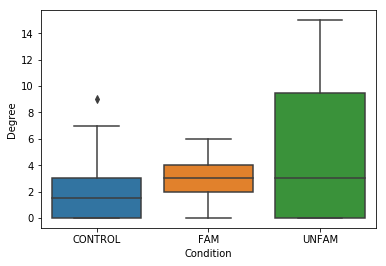

In [21]:
df_boxplot = pd.DataFrame({'CONTROL':list(dict(G_control.degree).values()), 
                           'FAM': list(dict(G_fam.degree).values()), 
                           'UNFAM':list(dict(G_unfam.degree).values())})
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_boxplot, ax=ax)
ax.set_xlabel('Condition')
ax.set_ylabel('Degree')

## Overall correlations

Text(0.5, 0.98, 'Correlations of all areas')

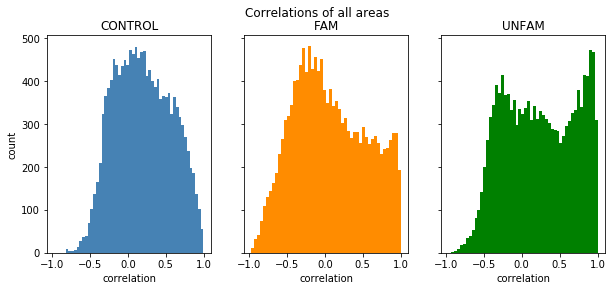

In [22]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
colors = ['steelblue', 'darkorange', 'green']
for i, corr in enumerate([corr_matrix_control_ncells, 
                          corr_matrix_fam_ncells, 
                          corr_matrix_unfam_ncells]):
    axes[i].hist(corr.mask(np.triu(np.ones(corr.shape)).astype(bool)).stack().values,
            color=colors[i], bins=50)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlations of all areas')

## Look at betweenness for graphs

Text(0, 0.5, 'Average Betweenness Centrality')

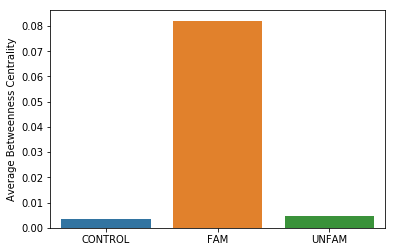

In [29]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
betweenness_centrality = [nx.betweenness_centrality(G) for G in graphs]
df_betweenness_centrality = pd.DataFrame({'CONTROL': [np.mean(list(betweenness_centrality[0].values()))], 
                                'FAM': [np.mean(list(betweenness_centrality[1].values()))],
                                'UNFAM': [np.mean(list(betweenness_centrality[2].values()))]})
sns.barplot(data=df_betweenness_centrality, ax=axes)
axes.set_ylabel('Average Betweenness Centrality')

In [37]:
def plot_betweenness(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes, level=8)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(10, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes,
                            macroareas_to_exclude=['Pons', 'Medulla', 'Cerebellar cortex', 'Cerebellar nuclei'])[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        betweenness = [nx.betweenness_centrality(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= betweenness)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes,
                            macroareas_to_exclude=['Pons', 'Medulla', 'Cerebellar cortex', 'Cerebellar nuclei'])[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Betweenness")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

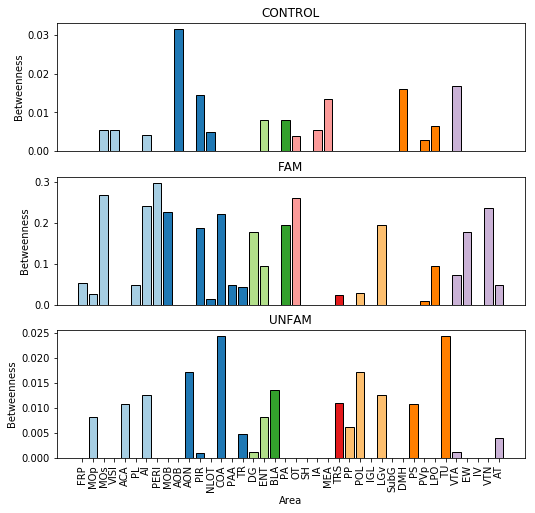

In [38]:
plot_betweenness(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

## Look at degree centrality


The degree centrality for a node v is the fraction of nodes it is connected to.

Text(0, 0.5, 'Average degree Centrality')

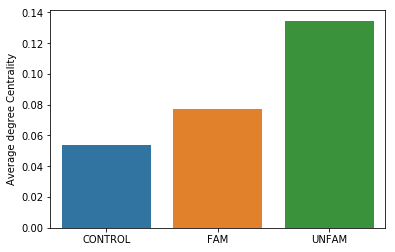

In [39]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
degree_centrality = [nx.degree_centrality(G) for G in graphs]
df_degree_centrality = pd.DataFrame({'CONTROL': [np.mean(list(degree_centrality[0].values()))], 
                                'FAM': [np.mean(list(degree_centrality[1].values()))],
                                'UNFAM': [np.mean(list(degree_centrality[2].values()))]})
sns.barplot(data=df_degree_centrality, ax=axes)
axes.set_ylabel('Average degree Centrality')

In [40]:
def plot_degree_centrality(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes, level=8)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(10, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes,
                            macroareas_to_exclude=['Pons', 'Medulla', 'Cerebellar cortex', 'Cerebellar nuclei'])[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        degree_centrality = [nx.degree_centrality(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= degree_centrality)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes,
                            macroareas_to_exclude=['Pons', 'Medulla', 'Cerebellar cortex', 'Cerebellar nuclei'])[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Degree Centrality")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

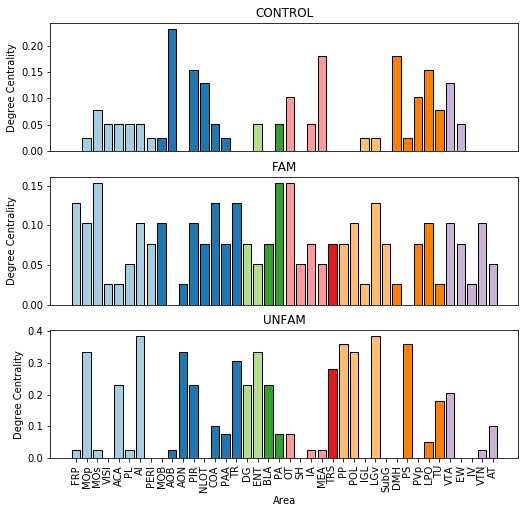

In [41]:
plot_degree_centrality(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

## Efficiency

The efficiency of a pair of nodes in a graph is the multiplicative inverse of the shortest path distance between the nodes. The average global efficiency of a graph is the average efficiency of all pairs of nodes

Text(0, 0.5, 'Global efficiency')

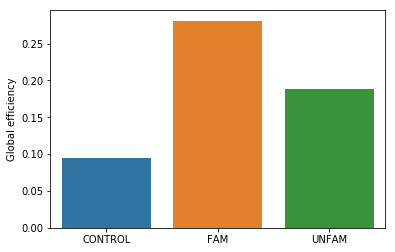

In [42]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
efficiencies = [nx.global_efficiency(G) for G in graphs]
df_efficiencies = pd.DataFrame({'CONTROL': [efficiencies[0]], 
                                'FAM': [efficiencies[1]],
                                'UNFAM': [efficiencies[2]]})
sns.barplot(data=df_efficiencies, ax=axes)
axes.set_ylabel('Global efficiency')

## Clustering

For weighted graphs, there are several ways to define clustering [1]. the one used here is defined as the geometric average of the subgraph edge weights [2],

Text(0, 0.5, 'Clustering')

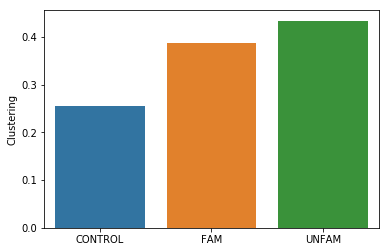

In [43]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
clustering = [nx.clustering(G) for G in graphs]
df_clustering = pd.DataFrame({'CONTROL': [np.mean(list(clustering[0].values()))], 
                                'FAM': [np.mean(list(clustering[1].values()))],
                                'UNFAM': [np.mean(list(clustering[2].values()))]})
sns.barplot(data=df_clustering, ax=axes)
axes.set_ylabel('Clustering')

In [44]:
def plot_clustering(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes, level=8)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(10, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes,
                            macroareas_to_exclude=['Pons', 'Medulla', 'Cerebellar cortex', 'Cerebellar nuclei'])[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        clustering = [nx.clustering(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= clustering)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes,
                            macroareas_to_exclude=['Pons', 'Medulla', 'Cerebellar cortex', 'Cerebellar nuclei'])[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Clustering Coefficient")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

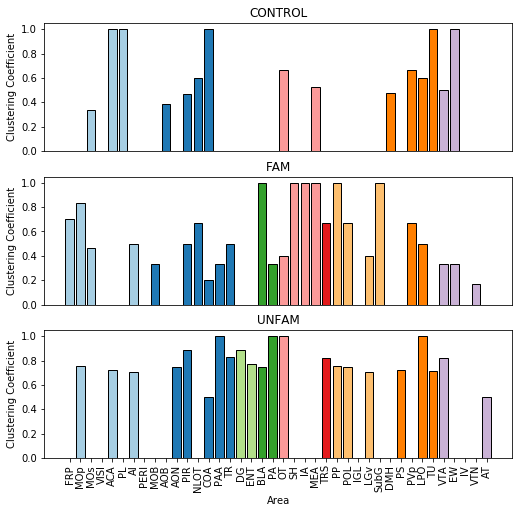

In [45]:
plot_clustering(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

## Rich club coefficient
Returns the rich-club coefficient of the graph G.

For each degree k, the rich-club coefficient is the ratio of the number of actual to the number of potential edges for nodes with degree greater than k

Text(0, 0.5, 'Rich Club Coefficient')

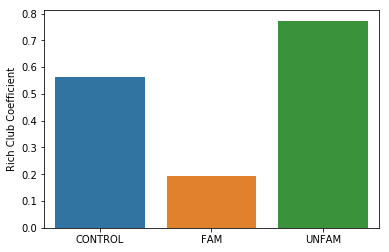

In [46]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
rich_club_coefficient = [nx.rich_club_coefficient(G, normalized=False) for G in graphs]
df_rich_club_coefficient = pd.DataFrame({'CONTROL': [np.mean(list(rich_club_coefficient[0].values()))], 
                                'FAM': [np.mean(list(rich_club_coefficient[1].values()))],
                                'UNFAM': [np.mean(list(rich_club_coefficient[2].values()))]})
sns.barplot(data=df_rich_club_coefficient, ax=axes)
axes.set_ylabel('Rich Club Coefficient')

## Small-World coefficient
Functions for estimating the small-world-ness of graphs.

A small world network is characterized by a small average shortest path length, and a large clustering coefficient.

Small-worldness is commonly measured with the coefficient sigma or omega.

Both coefficients compare the average clustering coefficient and shortest path length of a given graph against the same quantities for an equivalent random or lattice graph.

For more information, see the Wikipedia article on small-world network [1].

### Sigma

Returns the small-world coefficient (sigma) of the given graph.

The small-world coefficient is defined as: sigma = C/Cr / L/Lr where C and L are respectively the average clustering coefficient and average shortest path length of G. Cr and Lr are respectively the average clustering coefficient and average shortest path length of an equivalent random graph.

A graph is commonly classified as small-world if sigma>1.

In [ ]:
# fig, axes = plt.subplots(1,1)
# graphs=[G_control, G_fam, G_unfam]
# # calculate the small world coefficient on the largest connected component
# sigma = [nx.sigma(G.subgraph(max(nx.connected_components(G), key=len)).copy(), niter=10) for G in graphs]
# df_sigma = pd.DataFrame({'CONTROL': [sigma[0]], 
#                                 'FAM': [sigma[1]],
#                                 'UNFAM': [sigma[2]]})
# sns.barplot(data=df_sigma, ax=axes)
# axes.set_ylabel('Small World Coefficient (sigma)')

In [ ]:
# fig, axes = plt.subplots(1,1)
# graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
# # calculate the small world coefficient on the largest connected component
# sigma = [nx.sigma(G.subgraph(max(nx.connected_components(G), key=len)).copy(), niter=10) for G in graphs]
# df_sigma = pd.DataFrame({'CONTROL': [sigma[0]], 
#                                 'FAM': [sigma[1]],
#                                 'UNFAM': [sigma[2]]})
# sns.barplot(data=df_sigma, ax=axes)
# axes.set_ylabel('Small World Coefficient (sigma)')

### Omega

Returns the small-world coefficient (omega) of a graph

The small-world coefficient of a graph G is:

omega = Lr/L - C/Cl

where C and L are respectively the average clustering coefficient and average shortest path length of G. Lr is the average shortest path length of an equivalent random graph and Cl is the average clustering coefficient of an equivalent lattice graph.

The small-world coefficient (omega) measures how much G is like a lattice or a random graph. Negative values mean G is similar to a lattice whereas positive values mean G is a random graph. Values close to 0 mean that G has small-world characteristics.

In [ ]:
# fig, axes = plt.subplots(1,1)
# graphs=[G_control, G_fam, G_unfam]
# # calculate the small world coefficient on the largest connected component
# omega = [nx.omega(G.subgraph(max(nx.connected_components(G), key=len)).copy()) for G in graphs]
# df_omega = pd.DataFrame({'CONTROL': [omega[0]], 
#                                 'FAM': [omega[1]],
#                                 'UNFAM': [omega[2]]})
# sns.barplot(data=df_omega, ax=axes)
# axes.set_ylabel('Small World Coefficient (omega)')

In [ ]:
# fig, axes = plt.subplots(1,1)
# graphs=[G_control_pls, G_fam_pls, G_unfam_pls]
# # calculate the small world coefficient on the largest connected component
# omega = [nx.omega(G.subgraph(max(nx.connected_components(G), key=len)).copy()) for G in graphs]
# df_omega = pd.DataFrame({'CONTROL': [omega[0]], 
#                                 'FAM': [omega[1]],
#                                 'UNFAM': [omega[2]]})
# sns.barplot(data=df_omega, ax=axes)
# axes.set_ylabel('Small World Coefficient (omega)')